In [508]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [509]:
insecure = pd.read_csv("insecure.csv")
demandPagingMemoryConsumption = pd.read_csv("stack_heap_sizes_demand_paging.csv")
outOfEnclaveMemoryConsumption = pd.read_csv("stack_heap_sizes_out_of_enclave.csv")
dp = pd.read_csv("demand_paging.csv")
ooe = pd.read_csv("out_of_enclave.csv")
untrusted = pd.read_csv("untrusted.csv")



In [510]:
def getNumLocks(data):
  numLocks = set()
  for locks in data["locks"]:
        numLocks.add(locks) # because two transactions acquire given amount of locks
  listNumLocks =  list(numLocks)
  listNumLocks.sort()
  return listNumLocks

# An experiment with the same parameters (number of locks, number of threads)
# is repeated multiple times. 
# This function computes the average runtime in nanoseconds over those repititions.
def averages_of_repeated_experiments(data, num_threads):
  averages = []
  numLocks = getNumLocks(data)
  for n in numLocks:
    sum = 0
    count = 0
    for i, row in data.iterrows():
      if row["locks"] == n and row["threads"] == num_threads:
        count += 1
        sum += row["nanoseconds"]
    averages.append((sum/count) / (10 ** 9)); # average, from nanoseconds to seconds
  return averages


# Plots the runtime in nanoseconds it takes to acquire the given number of locks as a line graph.
def plot_runtime(data, numThreads, labels, colors, title):

  fig = plt.figure(figsize=(15, 5))
  ax = fig.add_subplot(111)

  for threads, color, label in zip(numThreads, colors, labels):    
    averages = averages_of_repeated_experiments(data, threads)
    ax.plot(getNumLocks(data), averages, color, label=label, ms=8)

  plt.legend()
  plt.title(title)
  plt.xlabel("Number of locks acquired")
  plt.ylabel("Runtime in seconds")
  plt.show()


# Plots the throughput of locks per second given the number of locks acquired as a line graph.
def plot_throughput(data, numThreads, labels, colors, title, lower_bound = 70000):
  fig = plt.figure(figsize=(15, 5))
  ax = fig.add_subplot(111)
  numLocks = getNumLocks(data)

  for threads, color, label in zip(numThreads, colors, labels):   
    throughput = []
    averages = averages_of_repeated_experiments(data, threads)
    for locks, duration in zip(numLocks, averages):
      if locks >= lower_bound:
        throughput.append(locks / duration)
    ax.plot(list(filter(lambda locks: locks >= lower_bound, numLocks)), throughput, color, label=label)

  plt.legend()
  plt.xlabel("Number of locks acquired")
  plt.ylabel("Throughput (Locks per second)")
  plt.title(title)
  plt.show()

# Plots the throughput of locks per second given the number of locks acquired as a line graph.
def plot_latency(data, numThreads, labels, colors, title, lower_bound = 70000):
  fig = plt.figure(figsize=(15, 5))
  ax = fig.add_subplot(111)
  numLocks = getNumLocks(data)

  for threads, color, label in zip(numThreads, colors, labels):   
    throughput = []
    averages = averages_of_repeated_experiments(data, threads)
    for locks, duration in zip(numLocks, averages):
      if locks >= lower_bound:
        throughput.append(duration / locks)
    ax.plot(list(filter(lambda locks: locks >= lower_bound, numLocks)), throughput, color, label=label)

  plt.legend()
  plt.xlabel("Number of locks acquired")
  plt.ylabel("Latency (Seconds per lock)")
  plt.title(title)
plt.show()

def plot_memory_consumption(data1, data2):
  fig = plt.figure(figsize=(15,8))
  ax = fig.add_subplot(111)
  ax.plot(data1["locks"], data1["stackKB"].divide(1000), "ro-", label="Peak stack used (Demand Paging)")
  ax.plot(data1["locks"], data1["heapKB"].divide(1000), "bo-", label="Peak heap used (Demand Paging)")
  ax.plot(data2["locks"], data2["stackKB"].divide(1000), "r^-", label="Peak stack used (Out-of-enclave)")
  ax.plot(data2["locks"], data2["heapKB"].divide(1000), "b^-", label="Peak heap used (Out-of-enclave)")

  x = np.linspace(0, 200000)
  y = 0 * x + 32
  ax.plot(x, y, "k--", label="Approx. start of paging")
  plt.legend()
  plt.xlabel("Number of locks acquired")
  plt.ylabel("Memory in MB")
  plt.title("Memory Consumption of Enclave")
  plt.show()





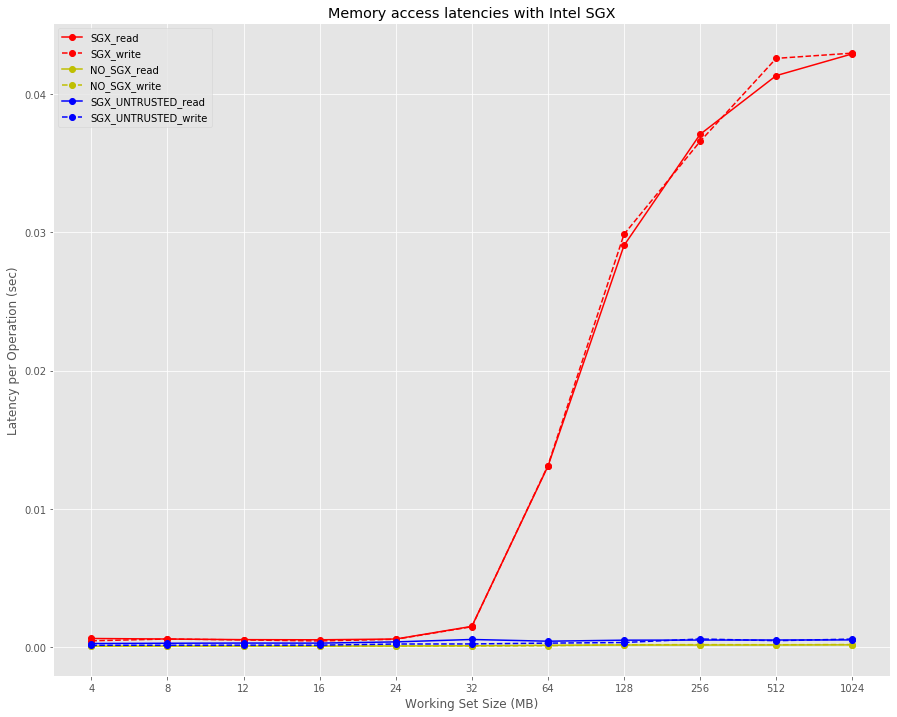

In [511]:
# gathered data (from the paging overhead experiment within the evaluation folder)
working_set_size_mb = ['4', '8', '12', '16', '24', '32', '64', '128', '256', '512', '1024']
SGX_latency_per_read_ns = [0.000613, 0.000574, 0.000529, 0.000519, 0.000574, 0.001490, 0.013078, 0.029058, 0.037102, 0.041350, 0.042926]
SGX_latency_per_write_ns = [0.000444, 0.000574, 0.000506, 0.000434, 0.000555, 0.001464, 0.013131, 0.029865, 0.036589, 0.042600, 0.042979]
NOSGX_latency_per_read_ns = [0.000059, 0.000064, 0.000068, 0.000066, 0.000070, 0.000085, 0.000124, 0.000141, 0.000138, 0.000142, 0.000151]
NOSGX_latency_per_write_ns = [0.000058, 0.000060, 0.000061, 0.000062, 0.000064, 0.000071, 0.000087, 0.000160, 0.000168, 0.000161, 0.000176]
SGX_UNTRUSTED_latency_per_read_ns = [0.000249, 0.000268, 0.000282, 0.000277, 0.000366, 0.000541, 0.000416, 0.000491, 0.000498, 0.000503, 0.000508]
SGX_UNTRUSTED_latency_per_write_ns = [0.000121, 0.000125, 0.000129, 0.000129, 0.000212, 0.000218, 0.000277, 0.000321, 0.000578, 0.000453, 0.000571]

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)  
ax.plot(working_set_size_mb, SGX_latency_per_read_ns, "ro-", label="SGX_read")
ax.plot(working_set_size_mb, SGX_latency_per_write_ns, "ro--", label="SGX_write")
ax.plot(working_set_size_mb, NOSGX_latency_per_read_ns, "yo-", label="NO_SGX_read")
ax.plot(working_set_size_mb, NOSGX_latency_per_write_ns, "yo--", label="NO_SGX_write")
ax.plot(working_set_size_mb, SGX_UNTRUSTED_latency_per_read_ns, "bo-", label="SGX_UNTRUSTED_read")
ax.plot(working_set_size_mb, SGX_UNTRUSTED_latency_per_write_ns, "bo--", label="SGX_UNTRUSTED_write")
plt.legend()
plt.title("Memory access latencies with Intel SGX")
plt.xlabel("Working Set Size (MB)")
plt.ylabel("Latency per Operation (sec)")
plt.show()

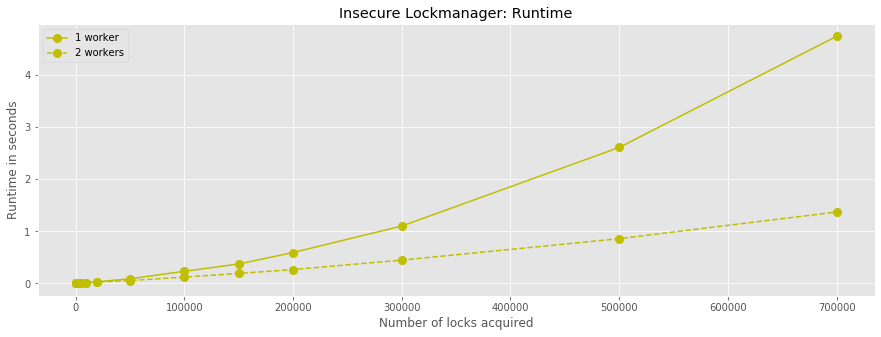

In [512]:
plot_runtime(insecure, numThreads=[1, 2], labels=["1 worker", "2 workers"], colors=["yo-", "yo--"], title="Insecure Lockmanager: Runtime")

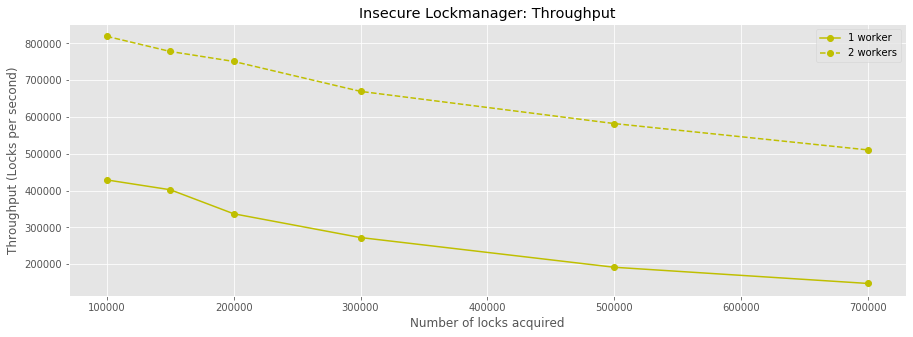

In [513]:
plot_throughput(insecure, numThreads=[1,2], labels=["1 worker", "2 workers"], colors=["yo-", "yo--"], title="Insecure Lockmanager: Throughput")

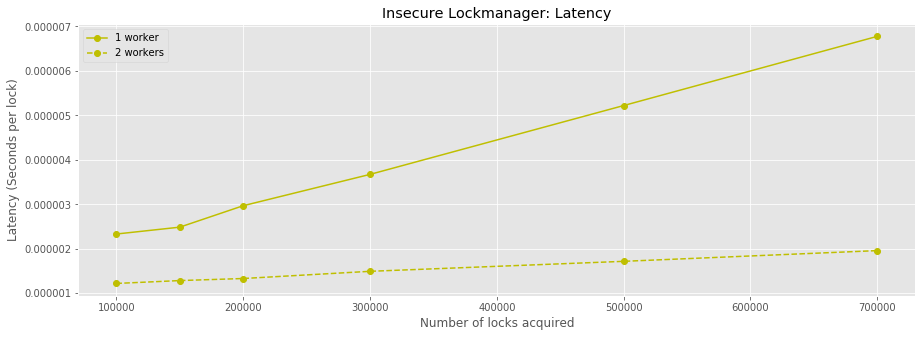

In [514]:
plot_latency(insecure, numThreads=[1,2], labels=["1 worker", "2 workers"], colors=["yo-", "yo--"], title="Insecure Lockmanager: Latency")

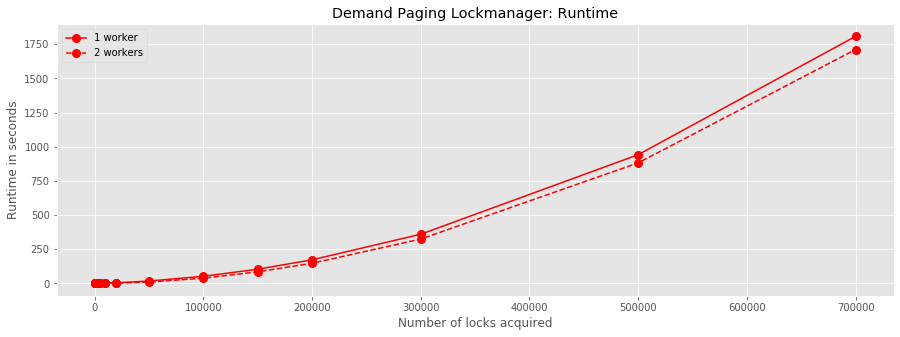

In [515]:
plot_runtime(dp, numThreads=[1, 2], labels=["1 worker", "2 workers"], colors=["ro-", "ro--"], title="Demand Paging Lockmanager: Runtime")

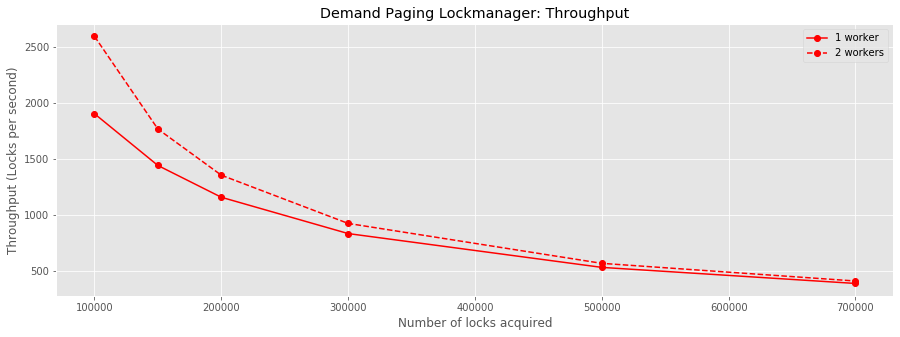

In [516]:
plot_throughput(dp, numThreads=[1, 2], labels=["1 worker", "2 workers"], colors=["ro-", "ro--"], title="Demand Paging Lockmanager: Throughput")

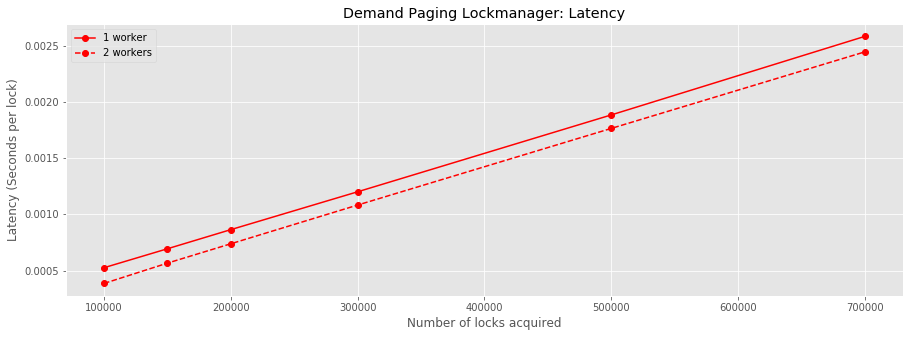

In [517]:
plot_latency(dp, numThreads=[1, 2], labels=["1 worker", "2 workers"], colors=["ro-", "ro--"], title="Demand Paging Lockmanager: Latency")

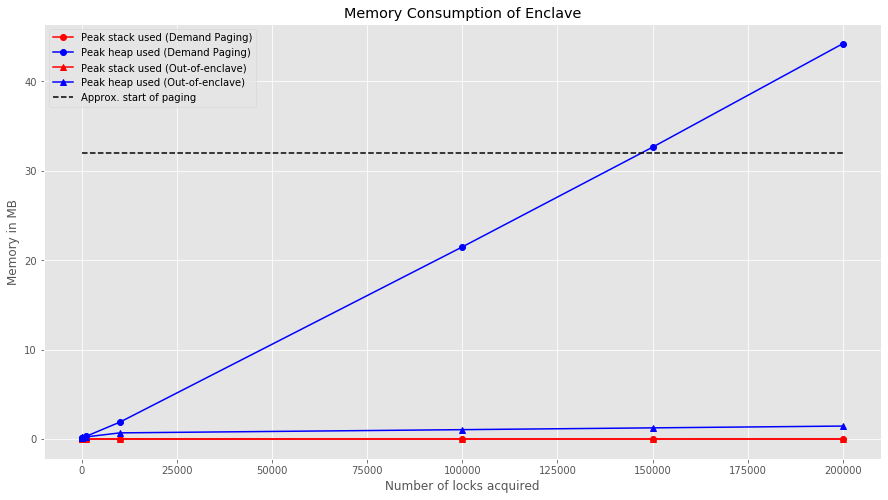

In [518]:
plot_memory_consumption(demandPagingMemoryConsumption, outOfEnclaveMemoryConsumption)

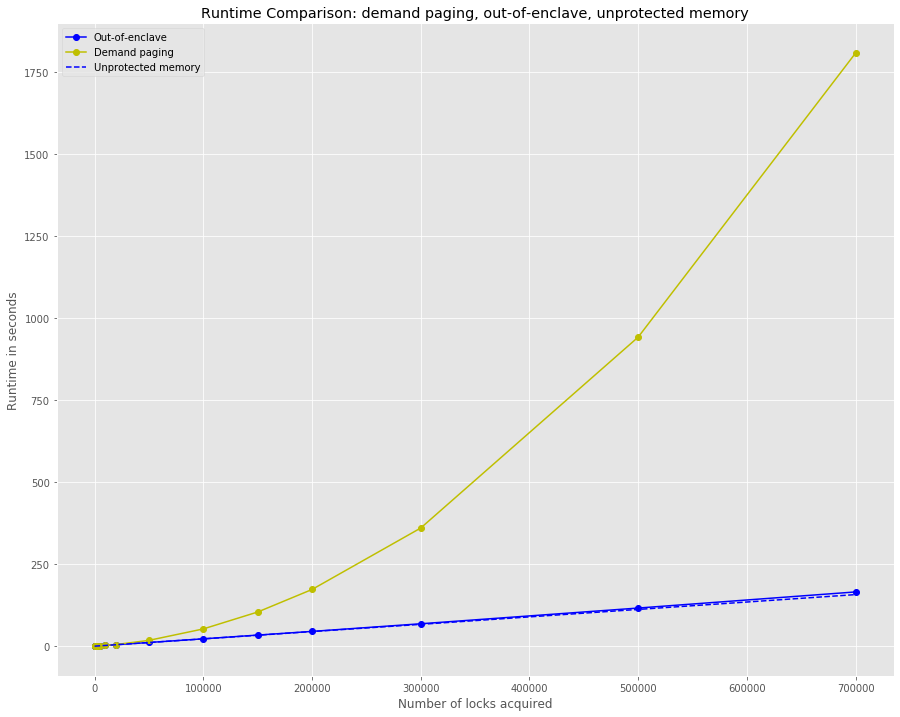

In [525]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)
    
ax.plot(getNumLocks(ooe), averages_of_repeated_experiments(ooe, 1), "bo-", label="Out-of-enclave")
ax.plot(getNumLocks(dp), averages_of_repeated_experiments(dp, 1), "yo-", label="Demand paging")
ax.plot(getNumLocks(untrusted), averages_of_repeated_experiments(untrusted, 1), "b--", label="Unprotected memory")

plt.legend()
plt.title("Runtime Comparison: demand paging, out-of-enclave, unprotected memory")
plt.xlabel("Number of locks acquired")
plt.ylabel("Runtime in seconds")
plt.show()

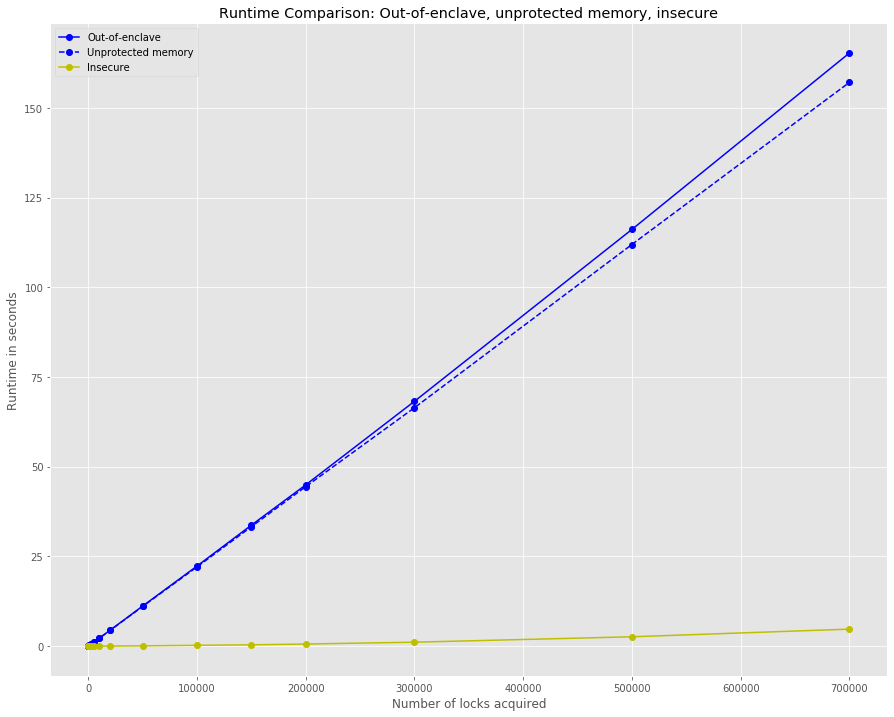

In [526]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)
    
ax.plot(getNumLocks(ooe), averages_of_repeated_experiments(ooe, 1), "bo-", label="Out-of-enclave")
ax.plot(getNumLocks(untrusted), averages_of_repeated_experiments(untrusted, 1), "bo--", label="Unprotected memory")
ax.plot(getNumLocks(insecure), averages_of_repeated_experiments(insecure, 1), "yo-", label="Insecure")

plt.legend()
plt.title("Runtime Comparison: Out-of-enclave, unprotected memory, insecure")
plt.xlabel("Number of locks acquired")
plt.ylabel("Runtime in seconds")
plt.show()

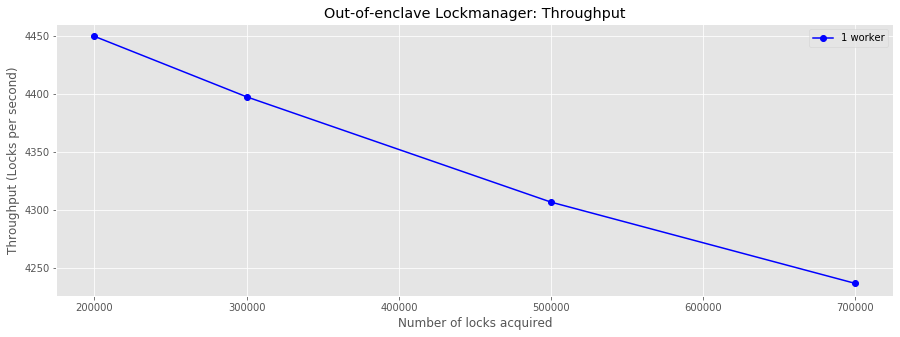

In [521]:
plot_throughput(ooe, numThreads=[1], labels=["1 worker"], colors=["bo-"], title="Out-of-enclave Lockmanager: Throughput", lower_bound=200000)

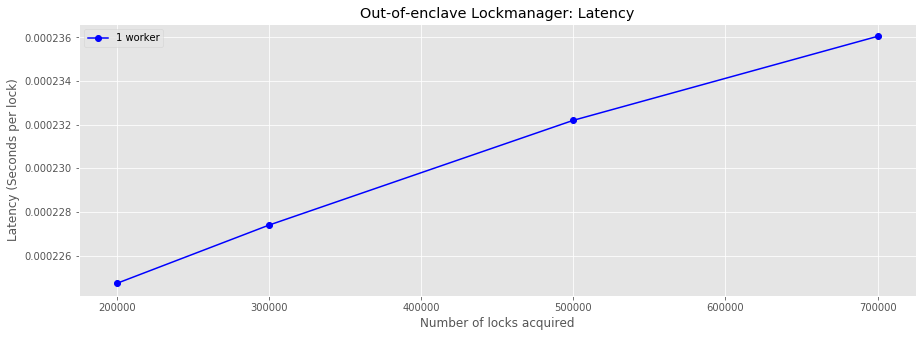

In [522]:
plot_latency(ooe, numThreads=[1], labels=["1 worker"], colors=["bo-"], title="Out-of-enclave Lockmanager: Latency", lower_bound=200000)